In [1]:
#-- Import Modules
import os
import glob
import rasterio
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
from skimage.morphology import binary_dilation

In [2]:
#-- directory setup
gdrive = os.path.expanduser('~/Google Drive File Stream/My Drive/')
indir = os.path.join(gdrive,'GL_Learning')
outdir = os.path.expanduser('~/GL_learning_data/geocoded_v1')

In [3]:
#-- get list of files
subdir = 'atrous_32init_drop0.2_customLossR727.dir'
# fileList = glob.glob(os.path.join(indir,'Train_predictions.dir',subdir,'pred*.png'))
fileList = glob.glob(os.path.join(indir,'Test_predictions.dir',subdir,'pred*.png'))
fileList[:5]

['/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_180907-180913-180919-180925_023591-012695-023766-012870_T110656_T110656_x1366_y1536_DIR01.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_180901-180907-180913-180919_012520-023591-012695-023766_T110455_T110456_x2048_y0512_DIR11.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_181206-181212-181218-181224_013920-024991-014095-025166_T110549_T110549_x1536_y2048_DIR11.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_181206-181212-181212-181218_013920-024991-024991-014095_T110456_T110537_x1536_y0000_DIR11.png',
 '/Users/yaramohajerani/Google Drive Fil

In [4]:
#-- make corresponding output folder
# out_subdir = os.path.join(outdir,'Train_predictions.dir',subdir)
out_subdir = os.path.join(outdir,'Test_predictions.dir',subdir)
if (not os.path.isdir(out_subdir)):
    os.mkdir(out_subdir)

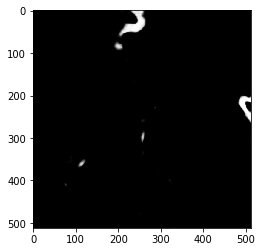

In [5]:
#-- Read an image to test
f = fileList[10]
im = imageio.imread(f).astype(float)/255.
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

In [8]:
print(im.max(),im.min())
print(np.count_nonzero(im > 0.5))
print(np.count_nonzero(im < 0.5))

1.0 0.0
8906
253238


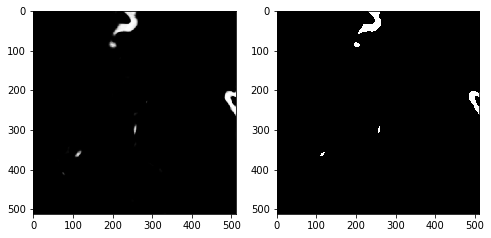

In [6]:
im2 = im.copy()
#-- threshold iamge
ii = np.where(im < 0.5)
jj = np.where(im >= 0.5)
im2[ii] = 0.
im2[jj] = 1.
fig,ax = plt.subplots(1, 2,figsize=(8,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im2, cmap=plt.cm.gray)
plt.show()

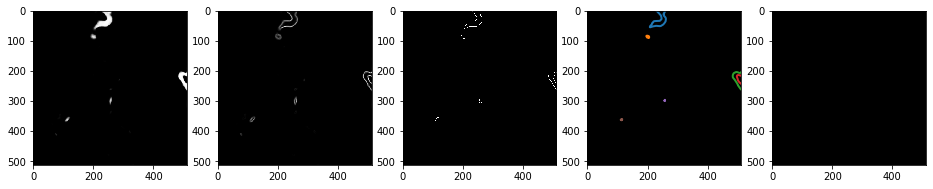

In [7]:
from skimage import filters
from skimage import feature
from skimage import measure
from skimage.morphology import skeletonize

edge_sobel = filters.sobel(im)
edge_canny = feature.canny(im,sigma=3)
contours = measure.find_contours(im, 0.8)
skeleton = skeletonize(im)

fig,ax = plt.subplots(1,5,figsize=(16,8))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].imshow(edge_canny, cmap=plt.cm.gray)
ax[3].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[4].imshow(skeleton, cmap=plt.cm.gray)
plt.show()

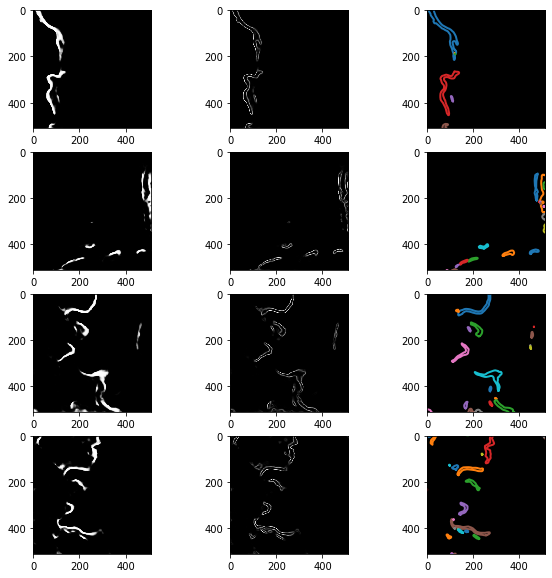

In [8]:
inds = [10,15,20,30]
fig,ax = plt.subplots(4,3,figsize=(10,10))
for j,i in enumerate(inds):
    f = fileList[i]
    im = imageio.imread(f).astype(float)/255.
    edge_sobel = filters.sobel(im)   
    contours = measure.find_contours(im, 0.6)
    ax[j,0].imshow(im, cmap=plt.cm.gray)
    ax[j,1].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[j,2].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        ax[j,2].plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

In [12]:
ii = np.where(im > 0.98)
print(ii[0][0],ii[1][0])
print(ii[0][-1],ii[1][-1])

1 133
510 135


In [13]:
#-- get route through array
ii = np.where(im > 0.98)
startPoint = (ii[0][-1],ii[1][-1])
endPoint = (ii[0][0],ii[1][0])

testIndices, testWeight = route_through_array(im, (startPoint[0], startPoint[1]),
                                              (endPoint[0], endPoint[1]), geometric=True,fully_connected=True)

In [14]:
testIndices = np.array(testIndices)
print(testIndices)
print(testIndices.shape)
print(im.size)

[[510 135]
 [510 134]
 [510 133]
 ...
 [  3 131]
 [  2 132]
 [  1 133]]
(16159, 2)
262144


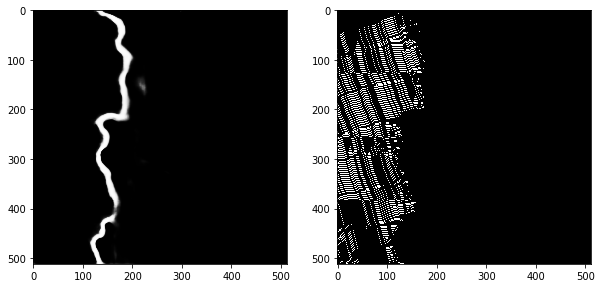

In [15]:
im_test = np.zeros(im.shape)
im_test[testIndices[:,0],testIndices[:,1]] = 1
# im_test[startPoint[0]-20:startPoint[0]+20, startPoint[1]-20:startPoint[1]+20] = 1
# im_test[endPoint[0], endPoint[1]] = 1
fig,ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im_test, cmap=plt.cm.gray)
plt.show()

## Run through all images and save contours

In [8]:
n_test=500
ddir = os.path.expanduser('~/Google Drive File Stream/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/geocoded_v1/')
train_dir = os.path.join(ddir,'train_n%i.dir'%n_test)
test_dir = os.path.join(ddir,'test_n%i.dir'%n_test)

In [9]:
#-- Get list of images
tempfileList = os.listdir(train_dir)
train_list = [f for f in tempfileList if (f.endswith('.npy') and f.startswith('coco'))]
tempfileList = os.listdir(test_dir)
test_list = [f for f in tempfileList if (f.endswith('.npy') and f.startswith('coco'))]

In [10]:
#-- get list of PREDICTION file names
file_list_name = [os.path.basename(f) for f in fileList]
#-- Read images and save to file
# for i,f in enumerate(train_list):
for i,f in enumerate(test_list):
    fig,ax = plt.subplots(1,5,figsize=(16,5))
        
    img = np.load(os.path.join(test_dir,f))
    lbl = binary_dilation(np.load(os.path.join(test_dir,f.replace('coco','delineation'))).reshape((im.shape[0],im.shape[1])))

    #-- find corresponding prediction file
    file_ind = file_list_name.index(f.replace('coco','pred').replace('.npy','.png'))
    im = imageio.imread(fileList[file_ind]).astype(float)/255. 
    contours = measure.find_contours(im, 0.3)
    ax[0].imshow(img[:,:,0],cmap='bwr',vmin=-2,vmax=2)
    ax[0].set_title('Real')
    ax[1].imshow(img[:,:,1],cmap='bwr',vmin=-2,vmax=2)
    ax[1].set_title('Imag')
    ax[2].imshow(lbl, cmap=plt.cm.gray)
    ax[2].set_title('Label')
    ax[3].imshow(im, cmap=plt.cm.gray)
    ax[3].set_title('Pred')
    ax[4].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        ax[4].plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax[4].set_title('Post')
    for ix in range(4):
        ax[ix].set_axis_off()
    plt.savefig(os.path.join(out_subdir,f.replace('coco','post').replace('.npy','.png')),format='PNG')
    plt.close()